<h3 style="color:#8D3DAF;">Importing necessary libraries</h3>

In [1]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(23)

<h3 style="color:#8D3DAF;">Resizing the original and mask images</h3>

In [2]:
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

<h3 style="color:#8D3DAF;">Getting the original and mask images path patterns</h3>

In [3]:
image_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*.jpg"
mask_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*.jpg"

<h3 style="color:#8D3DAF;">Sorting the images names of original images and their mask using the text before '.jpg'</h3>

<p style="color:#8D3DAF;"><strong>Operating system won't always load the images in the given order. So in order to get the correct pair of original image and its mask, this step is very important</strong></p>

In [4]:
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

<h3 style="color:#8D3DAF;">Loading the original images and their masks as an array and then adding them into a list and then creating an array out of it.</h3>

In [5]:
train_images_array = []

for image in image_names:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    train_images_array.append(img)
    
train_images_array = np.array(train_images_array)

In [6]:
mask_images_array = []

for mask in mask_names:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_images_array.append(msk)
    
mask_images_array = np.array(mask_images_array)

<h3 style="color:#8D3DAF;">Getting the dimensions of created array</h3>

In [7]:
len(train_images_array)

2841

In [8]:
len(mask_images_array)

2841

In [9]:
train_images_array[0].shape

(128, 128, 3)

In [10]:
mask_images_array[0].shape

(128, 128)

<h3 style="color:#8D3DAF;">Creating a function to normalize the created image and mask array</h3>

In [11]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(train_images_array)
y = normalize_array(mask_images_array)

<h3 style="color:#8D3DAF;">Visualizing random images from the original and mask images</h3>

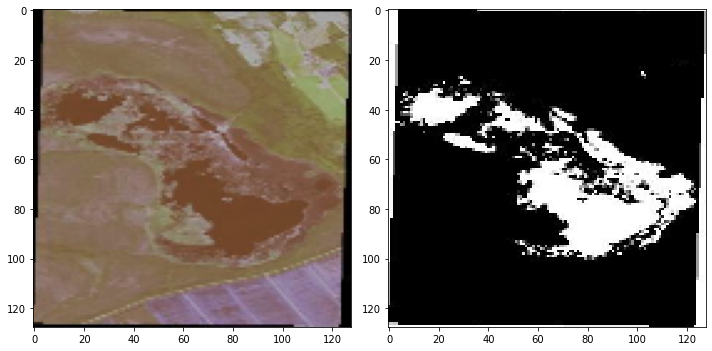

In [12]:
rand_num = random.randint(0,2500)

figure, axes = plt.subplots(1,2, figsize=(10,10))

axes[0].imshow(X[rand_num])

axes[1] = imshow(y[rand_num])

<h3 style="color:#8D3DAF;">splitting the image into train and test</h3>

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=23)

<h3 style="color:#8D3DAF;">Creating a function for the downward convolution in unet model</h3>

In [14]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

<h3 style="color:#8D3DAF;">Creating a function for upward convolution in unet model</h3>

In [15]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

<h3 style="color:#8D3DAF;">Creating a unet model using previous two functions</h3>

In [16]:
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<h3 style="color:#8D3DAF;">Creating and compiling the unet model</h3>

In [17]:
model = unet_model(n_filters=32,input_size=(128,128,3))

model.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

<h3 style="color:#8D3DAF;">Getting the summary of unet model</h3>

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

<h3 style="color:#8D3DAF;">Creating a callback for the unet model</h3>

In [19]:
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/kaggle/working/model.h5",save_best_only=True)

<h3 style="color:#8D3DAF;">Training the unet model...</h3>

In [20]:
num_epochs = 50

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/50
71/71 [==============================] - 27s 194ms/step - loss: 0.5476 - accuracy: 0.6122 - val_loss: 0.4990 - val_accuracy: 0.6424
Epoch 2/50
71/71 [==============================] - 12s 164ms/step - loss: 0.4536 - accuracy: 0.6739 - val_loss: 0.4148 - val_accuracy: 0.6996
Epoch 3/50
71/71 [==============================] - 12s 165ms/step - loss: 0.4333 - accuracy: 0.6855 - val_loss: 0.4274 - val_accuracy: 0.7019
Epoch 4/50
71/71 [==============================] - 12s 166ms/step - loss: 0.4086 - accuracy: 0.6974 - val_loss: 0.3688 - val_accuracy: 0.7164
Epoch 5/50
71/71 [==============================] - 12s 167ms/step - loss: 0.3796 - accuracy: 0.7092 - val_loss: 0.3963 - val_accuracy: 0.7114
Epoch 6/50
71/71 [==============================] - 12s 168ms/step - loss: 0.3767 - accuracy: 0.7087 - val_loss: 0.3729 - val_accuracy: 0.7168
Epoch 7/50
71/71 [==============================] - 12s 169ms/step - loss: 0.3486 - accuracy: 0.7238 - val_loss: 0.3369 - val_accuracy: 0.7408

<h3 style="color:#8D3DAF;">Visualizing the results of training</h3>

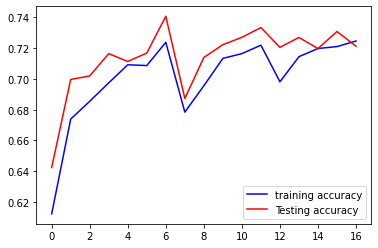

In [21]:
## creating an accuracy graph for training and testing data
plt.plot(history.history['accuracy'],color='blue',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

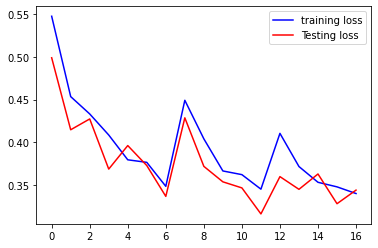

In [22]:
## creating an loss graph for training and testing data
plt.plot(history.history['loss'],color='blue',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

<h3 style="color:#8D3DAF;">Visualing the random original image, its original mask and predicted mask</h3>

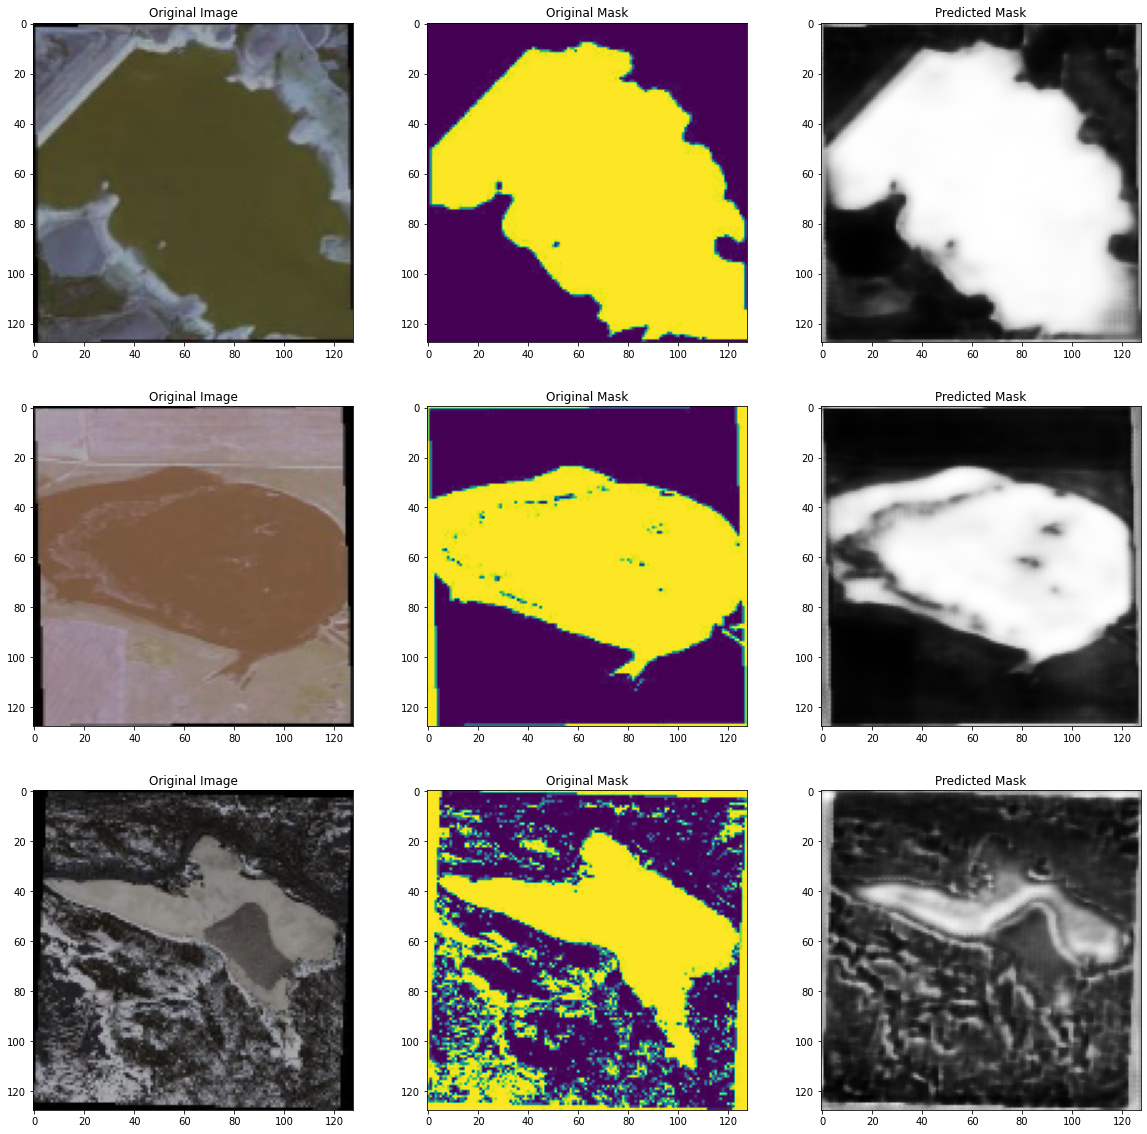

In [23]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,50)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')
    
    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')
    
    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask, cmap='gray')
    axes[i,2].title.set_text('Predicted Mask')
